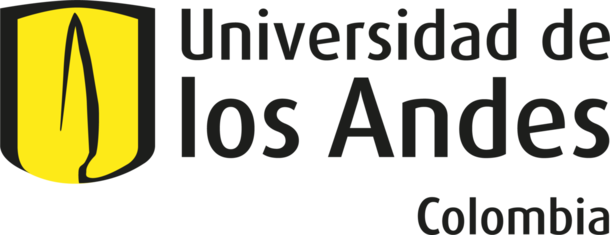

__ISIS3301 - Inteligencia de Negocios__

<div align="center">

## **Laboratorio 2: Regresión**
-------------------------------------

</div>


*   *Julián Castro - 202020847*
*   *Alejandro Gómez - 202015122*
*   *Jonathan Rivera -202022864*


## Objetivos



* Construir modelos analíticos para estimar una variable objetivo continua a partir de un conjunto de variables observadas.


* Comprender el proceso para la construcción de modelos analíticos que responden a una tarea de regresión.


* Automatizar el proceso de construcción de modelos analíticos con el uso de pipelines de tal forma que puedan ser usados en ambientes de producción.


* Extraer información útil para el negocio a partir de los resultados de los modelos de regresión.

## Caso de Negocio: Predicción de muertes per capita de cáncer

La Organización Mundial de la Salud está piloteando un nuevo programa de financiamiento que busca intervenir en poblaciones con un alto número de fallecimientos debido al cáncer. El objetivo es permitirle a los gobiernos nacionales y locales invertir en programas de diagnóstico temprano, instalaciones de tratamiento, entrenamiento de personal hospitalario y financiamiento de la investigación en esta enfermedad. Debido a que este programa busca beneficiar al mediano y largo plazo poblaciones vulnerables, se ha determinado la necesidad de crear un modelo predictivo para empezar interviniendo poblaciones que, dadas sus características, tengan un alto número de muertes por cáncer aunque no haya registros completos u oficiales.

Para ello y de la mano del gobierno norteamericano, la OMS ha recopilado datos de Estados Unidos para la creación del modelo a partir de diversas características demográficas y del estado de los servicios de salud de una población para determinar el número de muertes por cáncer por cada 100.000 habitantes. El objetivo, es que este modelo permita tomar decisiones de la asignación de finaciamiento del nuevo programa, además de determinar qué datos son relevantes y cuáles no lo son para la estimación y la recolección de información.

-----------------------------------------------

La OMS desea que usted los apoye en la construcción del modelo de regresión previamente descrito utilizando algunas de las etapas de la metodología "ASUM-DM":




__1. Entendimiento de los datos:__ Describir la característica más relevantes de los datos, incluir el análisis de calidad de datos y hacer una preselección de las variables más importantes para la etapa de modelado.


__2. Preparación de datos:__ Solucionar cualquier problema de calidad de datos previamente identificado. Además, debe aplicar cualquier proceso de preprocesamiento de datos necesario para la construcción del modelo de regresión.


__3. Modelado:__ Utilizando las variables previamente seleccionadas, construir un modelo de regresión que estime la variable objetivo con el menor error posible.


__4. Evaluación cuantitativa:__ A partir de las métricas seleccionadas para evaluar y seleccionar el mejor modelo, explicar el resultado obtenido desde el punto de vista cuantitativo. Contestar a la pregunta: ¿Su equipo recomienda utlizar en producción el modelo de estimación de precios de portátiles o es preferible continuar haciendo estimaciones de forma manual? En caso de no recomendar el uso del modelo, ¿qué recomendaciones haría para continuar iterando con el objetivo de la construcción de un mejor modelo?


__5. Evaluación cualitativa:__ Debe estar compuesta de dos partes:
- Validación de supuestos: Realizar los ajustes necesarios para que el modelo cumpla con los supuestos necesarios para la inferencia estadística con regresiones.
- Interpretación de los coeficientes: Realizar la interpretación de los coeficientes de la regresión, identificando las variables más relevantes para la estimación y como afectan la variable objetivo.


__6. Visualización de los resultados:__ Integrar el resultado obtenido con el modelo de regresión a un tablero de control para apoyar el objetivo de la empresa.


7. Exportar el mejor modelo (utilizando pipelines) para poder ser usado sobre datos nuevos en el ambiente de producción del cliente.


8. Generar predicciones sobre los datos de prueba que no se encuentran etiquetados utilizando el mejor modelo. Exportar las predicciones en formato CSV utlizando como base el mismo archivo de datos de prueba.

--------------------------------
# **1. Entendimiento de los datos**
--------------------------------

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 


In [2]:
# Se cargan los datos. 
df =pd.read_csv("./data/202410_Laboratorio 2 - Regresión_train_data.csv", sep=',', encoding = "ISO-8859-1")

In [3]:
# Tamaño del dataset: Filas y columnas
df.shape

(2132, 34)

In [4]:
# Se visualiza una muestra de los registros del dataset
df.sample(5)

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,...,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,deathRate
1094,4427.000000,1457,461.900000,80037,933736,7.9,214.193305,"(61494.5, 125635]",38.8,37.4,...,59.8,22.8,11.7,79.427178,4.707377,10.829611,2.385502,57.957957,4.783277,152.7
1088,270.000000,105,454.800000,38465,51542,20.1,0.000000,"(37413.8, 40362.7]",37.6,36.5,...,33.9,38.1,22.5,80.399476,14.577755,0.480779,1.670999,51.830334,5.031505,174.1
1138,1072.000000,420,509.600000,52448,186221,16.7,1610.989094,"(51046.4, 54545.6]",36.8,35.5,...,48.5,36.5,21.7,73.957309,17.530677,3.685493,1.397559,43.429262,6.690267,194.4
2018,136.000000,49,498.300000,42032,21543,16.7,0.000000,"(40362.7, 42724.4]",40.8,39.5,...,46.7,38.5,19.6,88.037597,8.725355,0.435580,0.444750,48.024922,3.072371,174.6
864,1962.667684,12,453.549422,36471,2605,17.4,0.000000,"(34218.1, 37413.8]",50.4,49.1,...,36.2,45.5,20.3,94.371972,0.782706,0.409989,0.447261,52.149682,3.050109,215.9


In [ ]:
# Revisar las características de los datos: completitud y tipo de dato
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915 entries, 0 to 914
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              915 non-null    float64
 1   avgDeathsPerYear         915 non-null    int64  
 2   incidenceRate            915 non-null    float64
 3   medIncome                915 non-null    int64  
 4   popEst2015               915 non-null    int64  
 5   povertyPercent           915 non-null    float64
 6   studyPerCap              915 non-null    float64
 7   binnedInc                915 non-null    object 
 8   MedianAge                915 non-null    float64
 9   MedianAgeMale            915 non-null    float64
 10  MedianAgeFemale          915 non-null    float64
 11  Geography                915 non-null    object 
 12  AvgHouseholdSize         915 non-null    float64
 13  PercentMarried           915 non-null    float64
 14  PctNoHS18_24             9

La columna binnedInc representa el ingreso mediano per capita del condado, para que esta información sea util debe ser representada de forma numerica, sin embargo se encuentra representada por el rango del decil en el que se encuentra el condado, por lo tanto si se desea usar, sera neceario tranformar esta informacion, esto se hara en la fase de preparacion de datos

In [ ]:
# Resumen de los estadisticos de las variables numéricas
df.describe()

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
count,915.000000,915.000000,915.000000,915.000000,9.150000e+02,915.000000,915.000000,915.000000,915.000000,915.000000,...,734.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,589.918086,191.622951,446.991992,47142.055738,1.029425e+05,16.851366,149.332917,47.540984,39.596940,42.157705,...,48.560763,41.099454,36.130383,19.140546,83.549674,9.050810,1.238772,2.053814,51.278641,5.631890
std,1371.603102,496.076994,56.784643,11886.716883,2.908374e+05,6.397277,520.406986,56.487479,5.270037,5.343377,...,10.311909,9.729474,7.831635,6.060371,15.892463,14.355963,2.264933,3.594692,6.593010,1.999869
min,7.000000,3.000000,261.100000,23047.000000,8.270000e+02,3.700000,0.000000,22.300000,22.400000,22.300000,...,23.000000,17.200000,13.500000,5.000000,11.008762,0.000000,0.000000,0.000000,23.915652,0.000000
25%,74.000000,28.000000,418.400000,38931.500000,1.208000e+04,12.100000,0.000000,37.800000,36.400000,39.100000,...,40.700000,33.650000,30.800000,14.800000,77.001247,0.650976,0.228215,0.326522,47.801630,4.528210
50%,162.000000,60.000000,453.549422,45207.000000,2.650300e+04,15.800000,0.000000,41.000000,39.500000,42.600000,...,48.400000,40.600000,36.300000,18.700000,89.637447,2.332149,0.575269,0.907175,51.815775,5.373954
75%,522.000000,162.500000,479.250000,52803.000000,7.708400e+04,20.500000,99.016393,44.000000,42.400000,45.200000,...,55.900000,47.850000,41.600000,23.000000,95.200448,10.203521,1.262916,2.180435,55.378149,6.550680
max,24965.000000,9445.000000,1206.900000,107250.000000,5.238216e+06,46.900000,9762.308998,624.000000,60.200000,58.200000,...,78.900000,69.200000,62.200000,41.400000,99.615279,75.536890,33.760905,41.930251,71.703057,18.556701


--------------------------------
### **Análisis de completitud**
--------------------------------

In [ ]:
# Cálculo de porcentaje de valores nulos por columna
((df.isnull().sum()/df.shape[0])).sort_values(ascending=False)

PctSomeCol18_24            0.744262
PctPrivateCoverageAlone    0.197814
PctEmployed16_Over         0.040437
PctBachDeg18_24            0.000000
PctMarriedHouseholds       0.000000
PctOtherRace               0.000000
PctAsian                   0.000000
PctBlack                   0.000000
PctWhite                   0.000000
PctPublicCoverageAlone     0.000000
PctPublicCoverage          0.000000
PctEmpPrivCoverage         0.000000
PctPrivateCoverage         0.000000
PctUnemployed16_Over       0.000000
PctBachDeg25_Over          0.000000
PctHS25_Over               0.000000
avgAnnCount                0.000000
avgDeathsPerYear           0.000000
PctHS18_24                 0.000000
PctNoHS18_24               0.000000
PercentMarried             0.000000
AvgHouseholdSize           0.000000
Geography                  0.000000
MedianAgeFemale            0.000000
MedianAgeMale              0.000000
MedianAge                  0.000000
binnedInc                  0.000000
studyPerCap                0

* La columna "PctSomeCol18_24" Tiene casi 3/4 de sus registros con valores nulos, por lo tanto su uso no proporcionaria informacion valiosa, sera necesario removerla en la fase de preparacion de datos
* La columna "PctPrivateCoverageAlone" tiene 20% de los registros en nulo. Es un numero significativo pero no mayoritario, podria considerarse remplazar los valores nulos por el promedio

In [5]:
#tomamos las variables numericas para visualizarlas
df_numericas = df.select_dtypes(include=['float64', 'int64'])

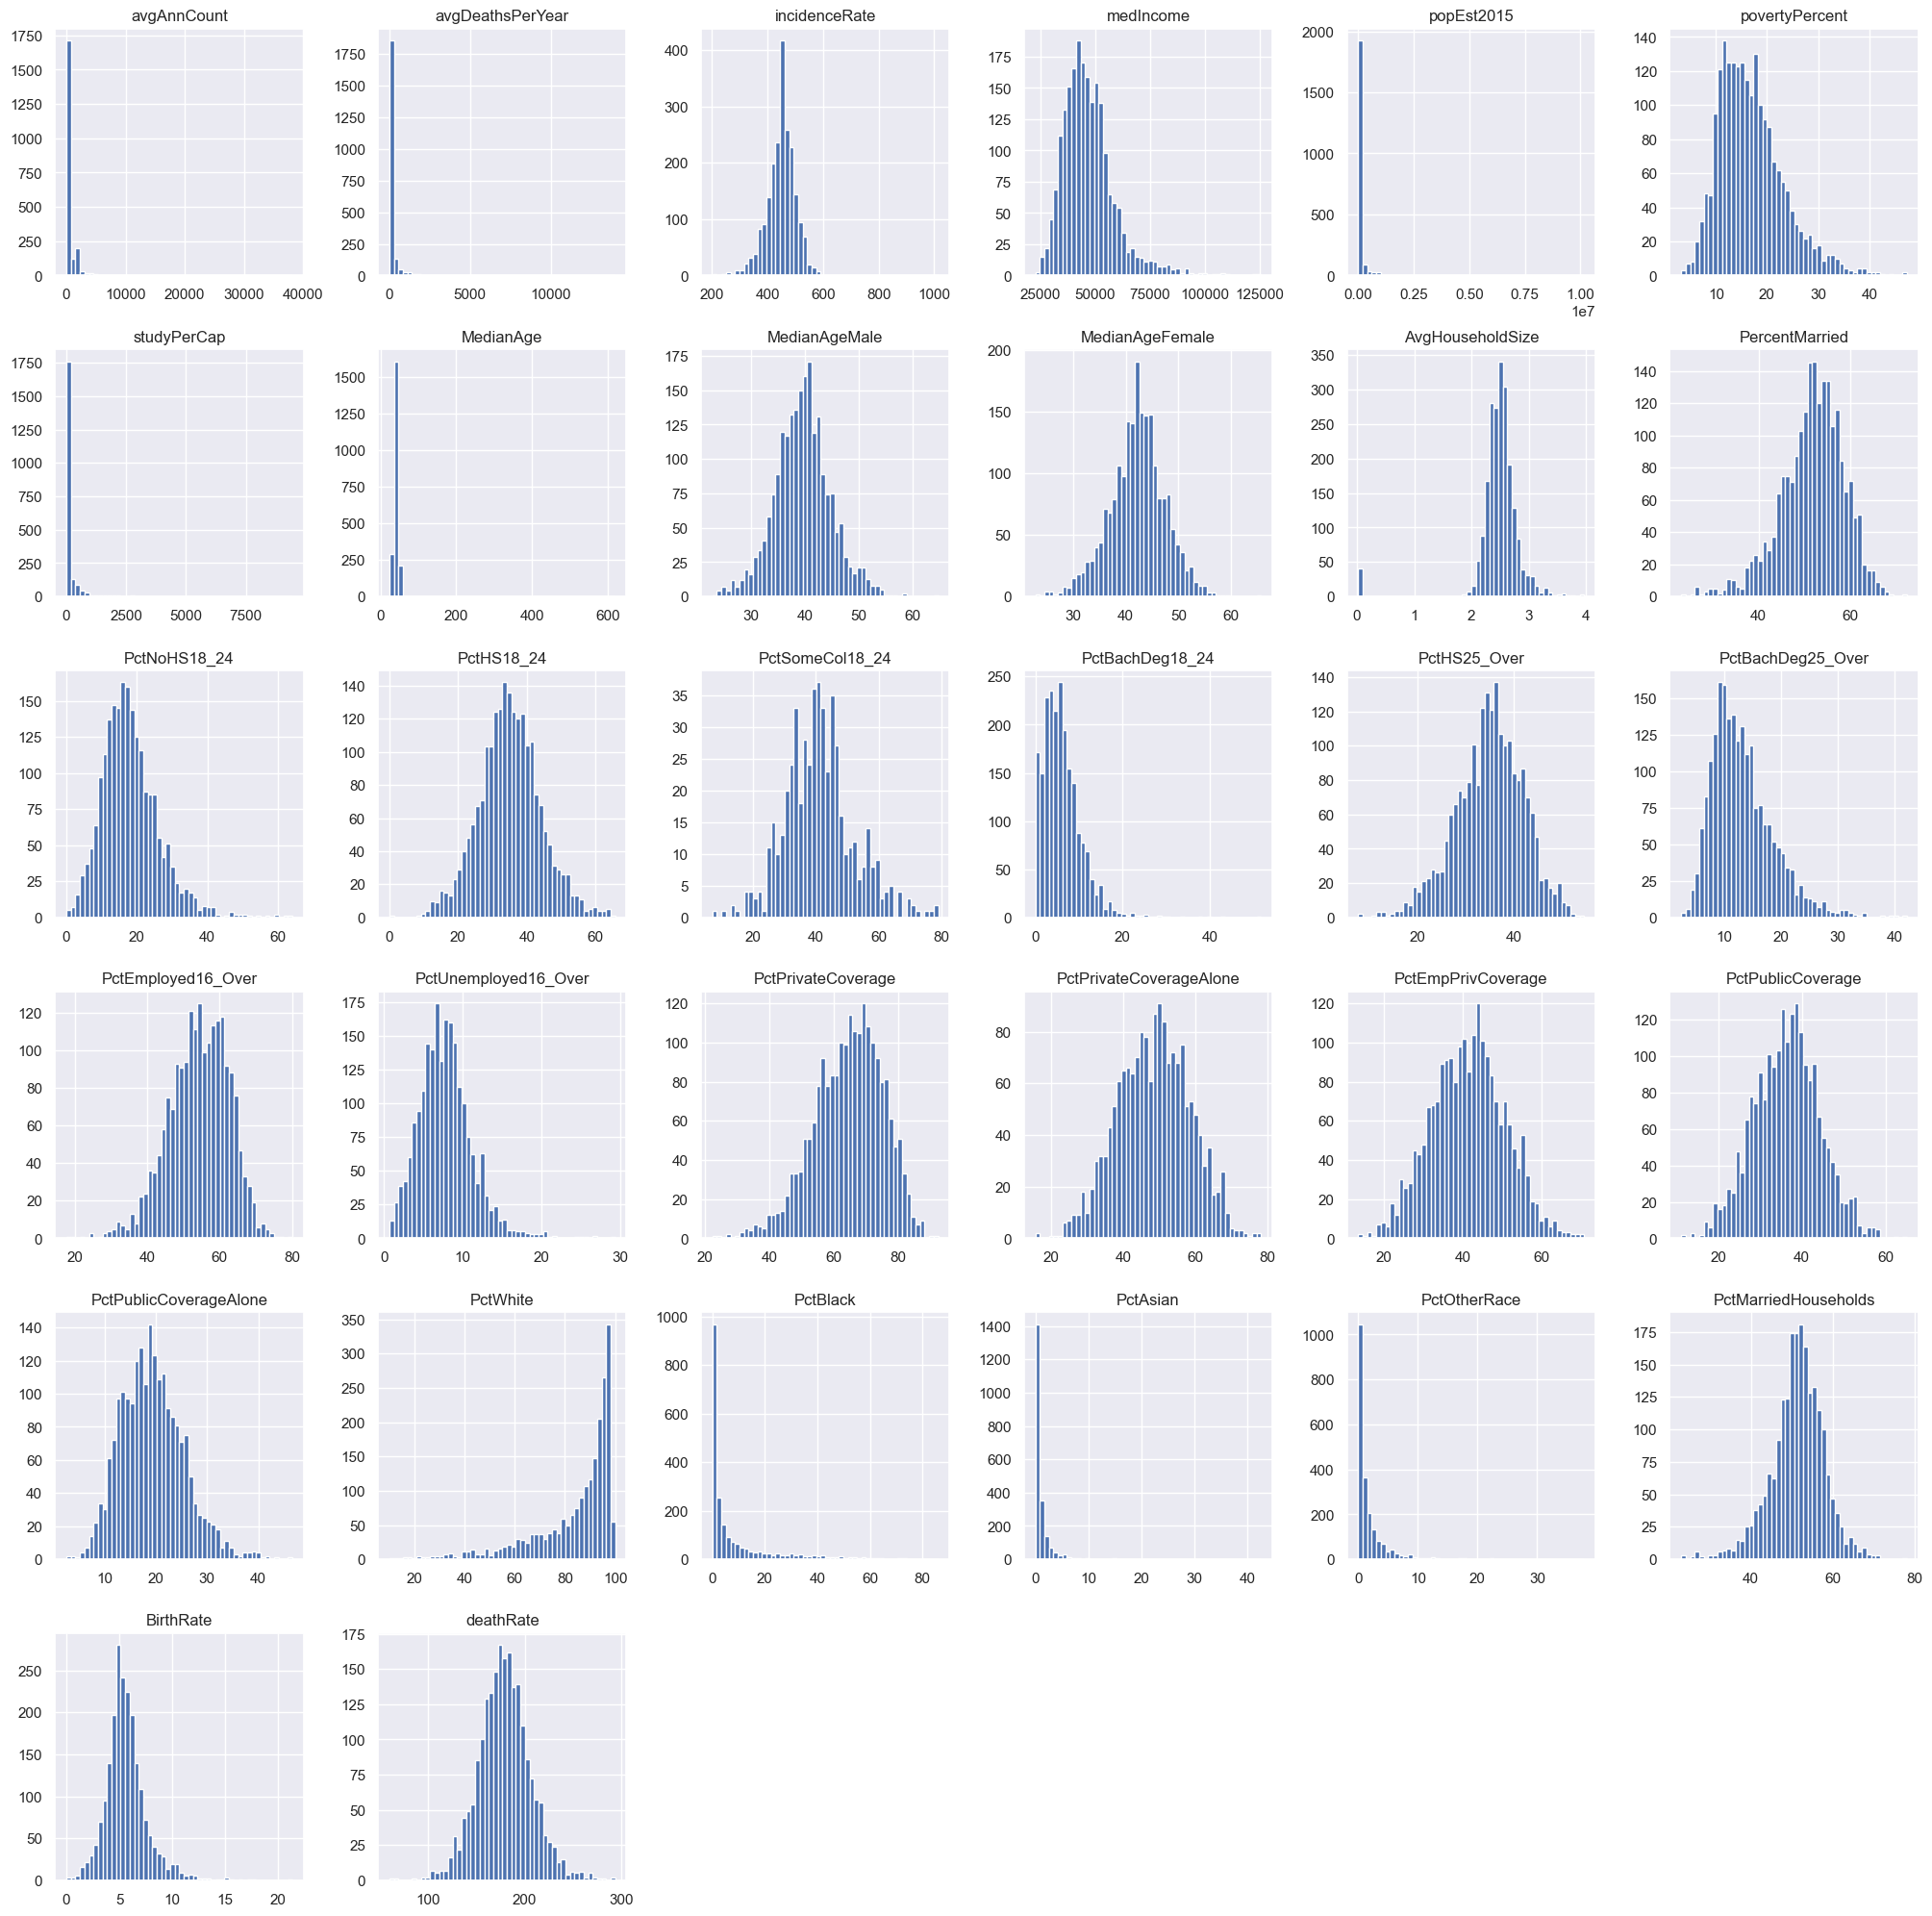

In [9]:
#Creamos un diagrama de distribucion para cada columna numerica
df_numericas.hist(bins=50, figsize=(25, 25))
plt.show()

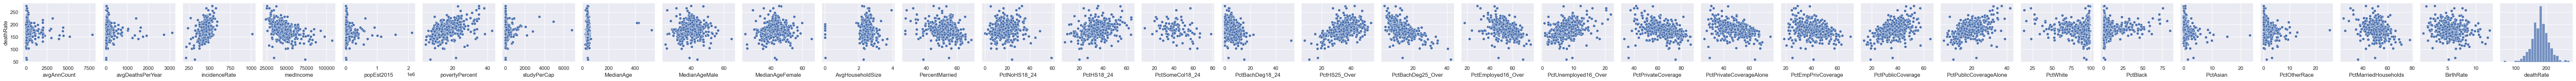

In [20]:
#Procedemos a visualizar la relacion entre las variables y la variable objetivo para validar el modelo posteriormente
sns.pairplot(df_numericas.sample(frac=0.2), y_vars="deathRate", x_vars=df_numericas, kind="scatter")

<Axes: >

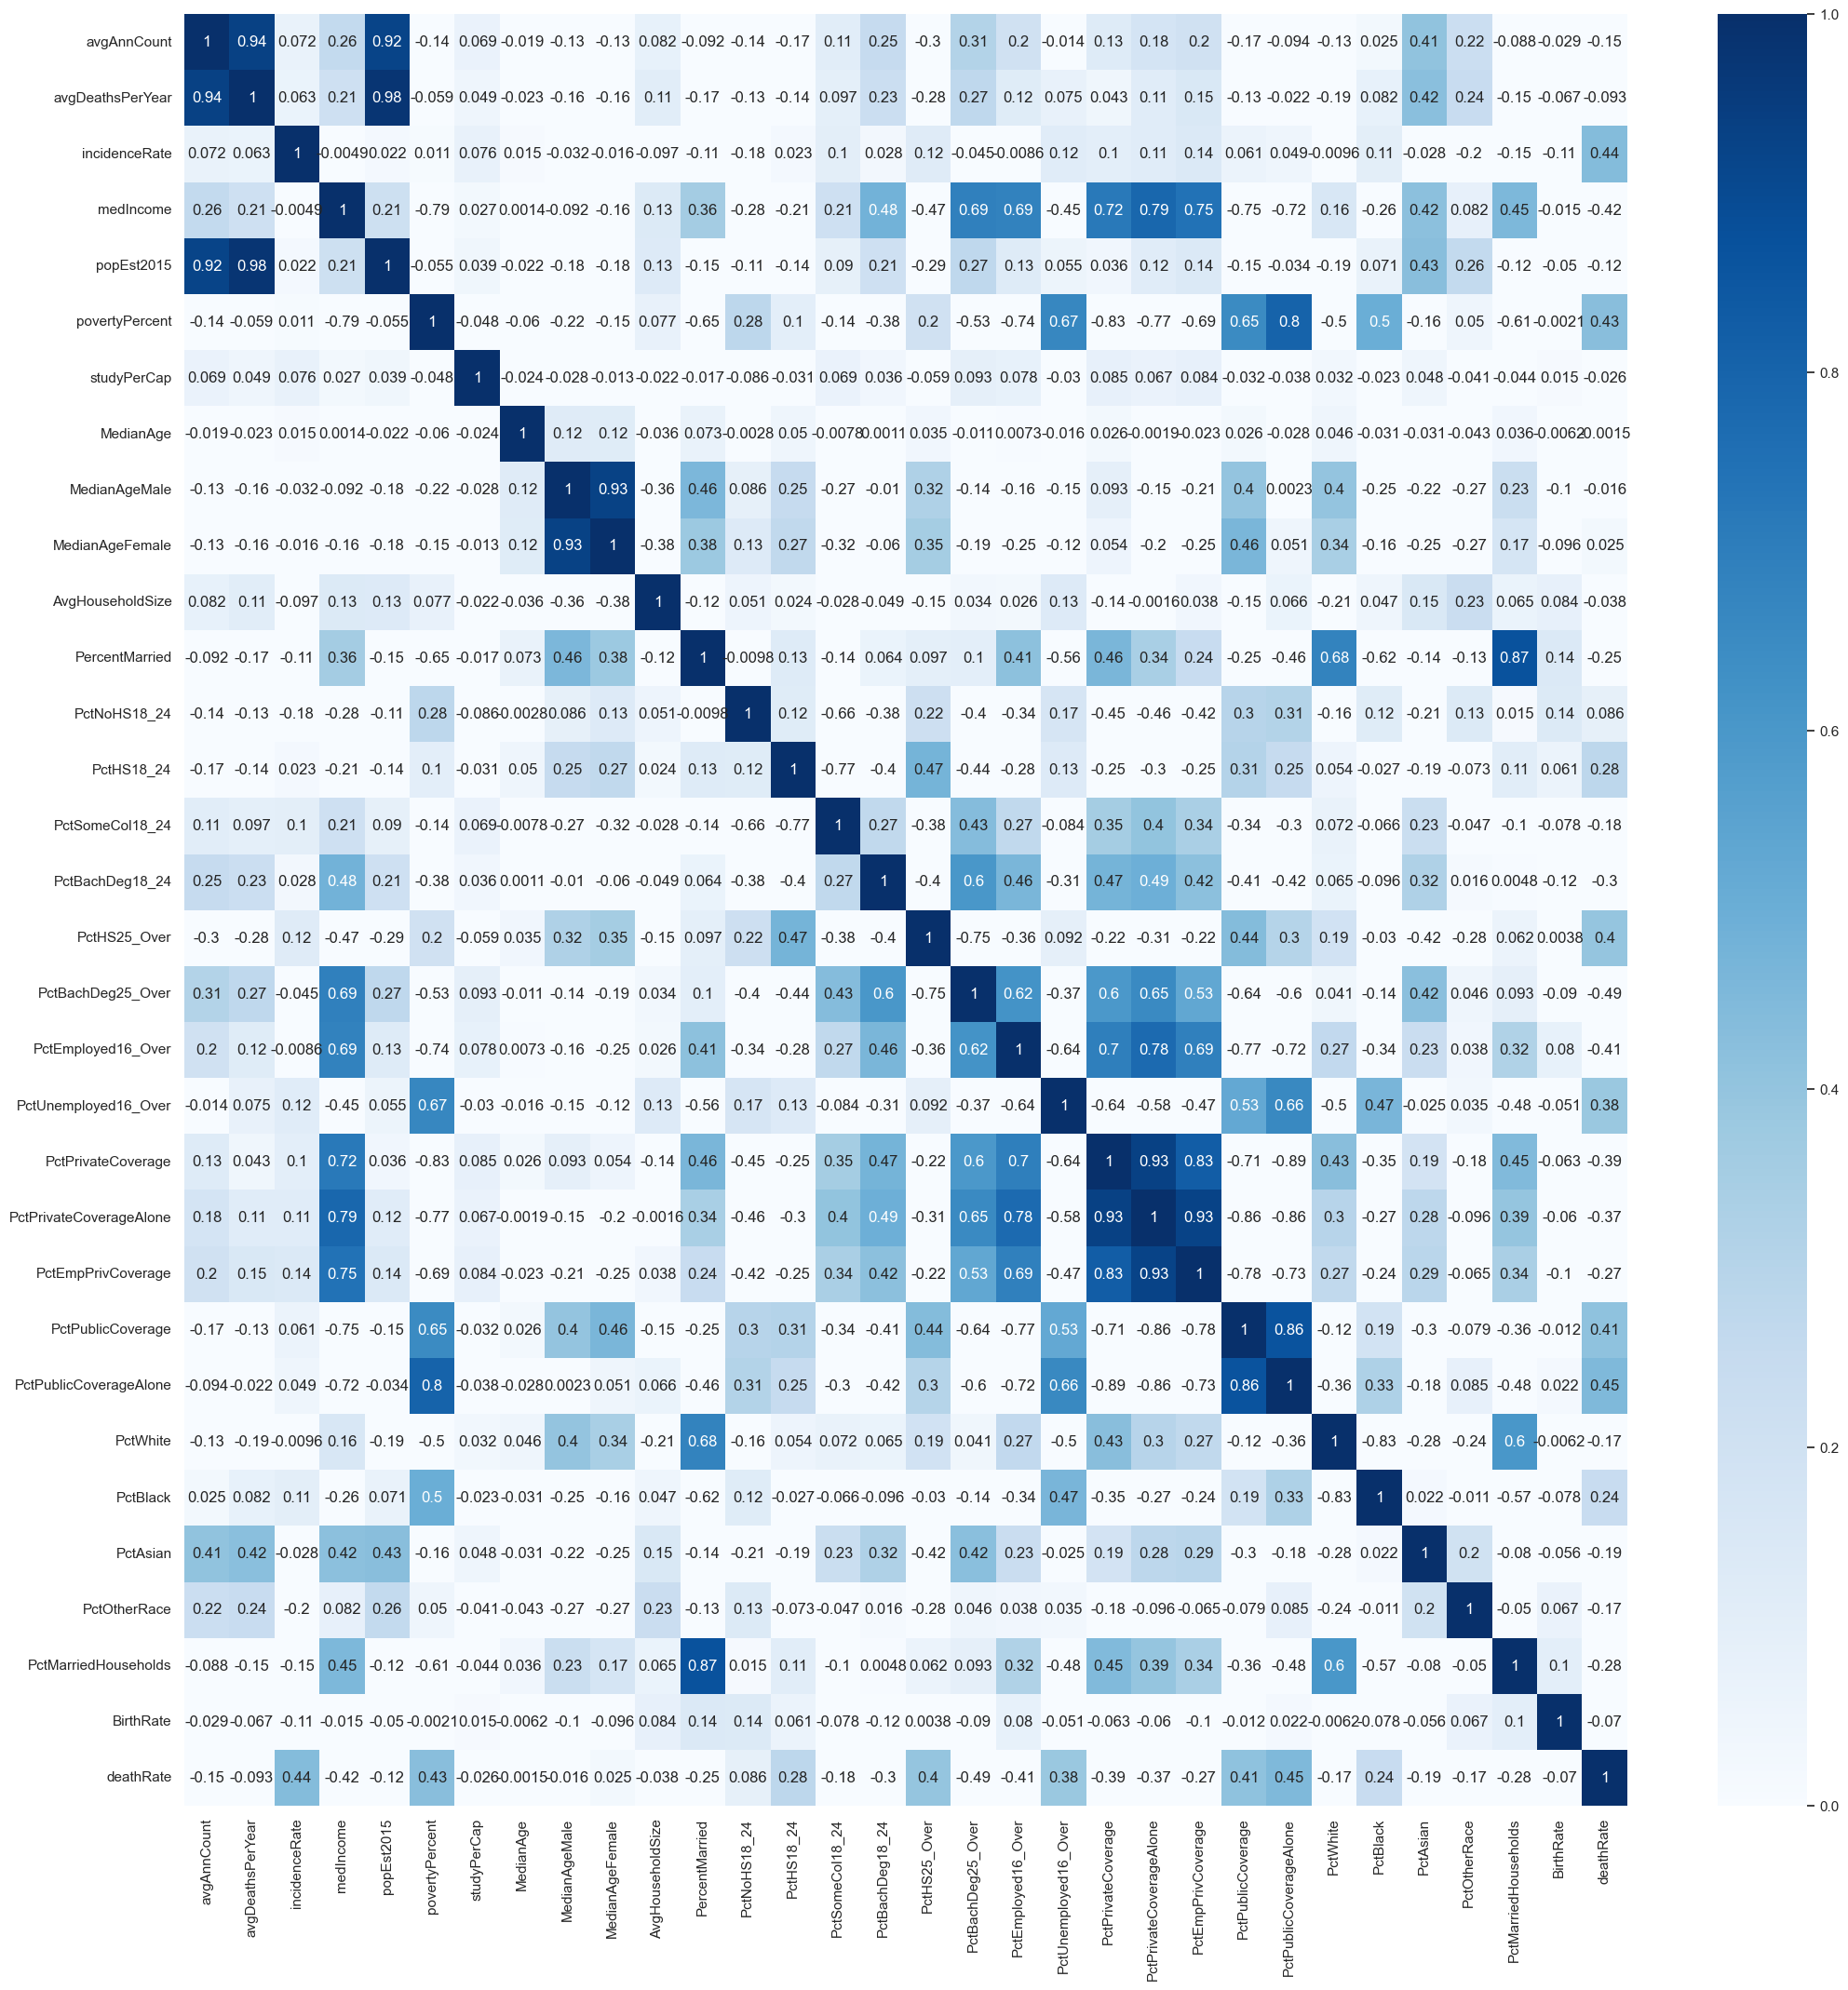

In [24]:
plt.figure(figsize=(25, 25))
sns.heatmap(df_numericas.corr(), cmap="Blues", vmin=0, vmax=1,annot=True)

--------------------------------
# **2. Preparación de datos**
--------------------------------

--------------------------------
# **3. Modelado**
--------------------------------

--------------------------------
# **4. Evaluación Cuantitativa**
--------------------------------

--------------------------------
# **1. Evaluación Cualitativa**
--------------------------------